## Assignment 13

# Vehicle tracking based on GPS and odometry data fusion

**Starodumova P., Antonov A., Babaev N., Krivova V. | Skoltech EDP course by Tatiana Podladchikova, 2020**

**The objective of this laboratory work is to develop a tracking filter to estimate a vehicle’s
dynamic state by assimilating the navigation data coming from different sources. The task
includes the fusion of GPS data (absolute positioning) and wheel odometry data (relative
positioning). Important outcome of this exercise is getting skill to solve the most fundamental
data fusion tasks for intelligent traffic applications.**

In [85]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import copy

## Part I. Assimilation of GPS data only (absolute positioning)

**Some secondary functions to develop Kalman filter algorithm and plot graphs:**

In [86]:
# plot graphs

def showPlease(arr,legend = [],xlabel ="x",ylabel="y",title="title"):
    params = {'legend.fontsize': 20,
          'legend.handlelength': 2}
    plt.rcParams.update(params)
    fig, ax = plt.subplots()
    max_len = 0
    for i in arr:
        if(len(i) > max_len):
            max_len = len(i)
    for i in arr:
        if(len(i) == max_len):
            plt.plot(i)
        else:
            plt.plot([j for j in range(max_len - len(i),max_len)],i)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    plt.grid()
    plt.xlabel(xlabel, fontsize = 16)
    plt.ylabel(ylabel, fontsize = 16)
    plt.legend(legend)
    plt.title(title, fontsize = 16);
    plt.show()

In [87]:
# return a vector

def vector(x):
    v = []
    for i in x:
        v.append([i])
        
    return np.matrix(v)

In [88]:
# return an array of elements 

def giveElements(vectors,index):
    x = []
    for i in range(0,len(vectors)):
        x.append((vectors[i][index].item(0)))
    return x

**Here we introduce the class to develop covariance matrix of measurement error R:**

In [89]:
class Data:
    def __init__(self, initialVectorX,teta,internalNoiseSigma,internalNoiseSigmaForKF = 0,F = None, H = None, G = None,initialVectorXK = None, initialMatrixP = None, 
                 externalNoiseSigma = None,typeOfProcess = "usual", optimalK = None,size = 500,T = 2,amount = 500):
        self.F = copy.deepcopy(F)
        self.H = copy.deepcopy(H)
        self.G = copy.deepcopy(G)
        #
        self.teta = teta
        self.internalNoiseSigma = internalNoiseSigma
        self.R = np.matrix([[externalNoiseSigma**2,0],
                            [0,externalNoiseSigma**2]])
        #
        self.T = T
        self.Q = 0 if typeOfProcess == "det" else self.G*self.G.T*(internalNoiseSigmaForKF**2)
        self.initialVectorX = copy.deepcopy(initialVectorX)
        self.initialVectorXK = initialVectorXK.copy() if initialVectorXK is not None else None
        self.initialMatrixP = copy.deepcopy(initialMatrixP)

        self.externalNoiseSigma = copy.deepcopy(externalNoiseSigma)

        self.optimalK = copy.deepcopy(optimalK)

        self.typeOfProcess = typeOfProcess
        self.amount = amount
        
        self.size = size - 2
        
    def calculateR(self):
        return self.R

**and the class to develop Kalman filter algorithm in order to estimate state vector — at every extrapolation and filtration, its components are calculated using extrapolated and filtered estimates:**

In [90]:
class KalmanFilter:
    def __init__(self,dataForKalman):
        self.dataForKalman = dataForKalman
        self.kalmanVectors = None
        self.listK = None
        self.listP = None
        self.length = len(self.dataForKalman.trueProcess)
        
    def calculateKalmanVectors(self):
        self.kalmanVectors = []
        self.kalmanVectorsPr = []
        self.listK = []
        self.listP = []
        self.listPtr = []
        prevX = copy.deepcopy(self.dataForKalman.initialVectorXK)
        prevP = copy.deepcopy(self.dataForKalman.initialMatrixP.copy())
        if(self.dataForKalman.optimalK is not None):
            K = dataForKalman.optimalK
            for i in range(2,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        else:
            for i in range(2,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                K = self.calculateK(predictedP,i)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        #self.calculatePol()
        
    def predict(self,prevX,prevP):
        F = self.dataForKalman.F
        Q = self.dataForKalman.Q
        x = F*prevX
        P = F*prevP*F.T + Q
        self.kalmanVectorsPr.append(x)
        self.listPtr.append(P)
        return x, P
    
    def calculateK(self,predictedP,index):
        H = self.dataForKalman.H
        R = self.dataForKalman.R
        K = predictedP*H.T*(H*predictedP*H.T + R)**(-1)
        self.listK.append(K)
        return K
    
    def filtrate(self,predictedX,predictedP,K,measIndex):
        H = copy.deepcopy(self.dataForKalman.H)
        meas = self.dataForKalman.measProcess[measIndex].copy()
        x = predictedX + K*(meas - H*predictedX)
        KH = K*H
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    def calculatePol(self):
        self.kalmanVectorsPol = []
        self.kalmanVectorsPolPr = []
        for i in self.kalmanVectors:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPol.append(vector([D,ang]))
        for i in self.kalmanVectorsPr:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPolPr.append(vector([D,ang]))
    
    def extrapolate(self,step):
        predictions = []
        F = self.dataForKalman.F
        for i in range(step-1,self.length):
            predictions.append((F**(step - 1))*self.kalmanVectors[i - step + 1])
        return predictions
    
    def errors(self,values,index):
        start = 0
        errors = []
        if(len(values) < self.length):
            start = length - len(values)
        for i in range(start,self.length):
            errors.append(self.dataForKalman.trueVectorsOfProcess[i][index][0] - values[i - start ])
        return errors

**The following function returns a true trajectory of a moving vehicle:**

In [91]:
def motion(data: Data):
    X = data.initialVectorX
    T = data.T
    size = data.size + 2
    Vx = X.item(1,0)
    Vy = X.item(3,0)
    ax = np.random.normal(0,data.internalNoiseSigma)
    ay = np.random.normal(0,data.internalNoiseSigma)
    processCor = [X.copy()]
    for i in range(1,size):
        x = processCor[-1].item(0,0) + 10*np.cos(teta[i-1])*T + ax*T**2/2
        y = processCor[-1].item(2,0) + 10*np.sin(teta[i-1])*T + ay*T**2/2
        processCor.append(vector([x,Vx,y,Vy]))
        ax = np.random.normal(0,data.internalNoiseSigma)
        ay = np.random.normal(0,data.internalNoiseSigma)
        Vx = 10 * np.cos(teta[i-1])
        Vy = 10 * np.sin(teta[i-1])
    data.trueProcess = copy.deepcopy(processCor)
    return processCor
        

**And this one returns measurements of navigation parameters:**

In [92]:
def meas(data):
    z = []
    process = copy.deepcopy(data.trueProcess)
    x = giveElements(process,0)
    y = giveElements(process,2)
    for i in range(0,len(process)):
        z.append(vector([x[i] + np.random.normal(0,data.externalNoiseSigma),y[i] + np.random.normal(0,data.externalNoiseSigma)]))
    data.measProcess = copy.deepcopy(z)
    data.initialVectorXK = np.matrix([[z[1].item(0)],
                             [(z[1].item(0) - z[0].item(0))/T],
                             [z[1].item(1)],
                             [(z[1].item(1) - z[0].item(1))/T]])
    return z

**Getting the data for angle Θ describing the orientation of a car:**

In [93]:
# size of trajectory is N = 500 points

with open('theta.txt', 'r') as text_file:
    lines = text_file.read().splitlines()
    teta = [float(i) for i in lines]

**Now we introduce initial conditions for true trajectory, measurements and Kalman filter algorithm:**

In [94]:
# time step
T = 0.05

# velocity which is constant over the whole observation interval 
Vabs = 10

# initial filtration error covariance matrix
initialPK = np.matrix([[10**4,0,0,0],
                       [0,10**4,0,0],
                       [0,0,10**4,0],
                       [0,0,0,10**4]])
# transition matrix
Phi = np.matrix([[1,T,0,0],
                 [0,1,0,0],
                 [0,0,1,T],
                 [0,0,0,1]])

# observation matrix
H = np.matrix([[1,0,0,0],
               [0,0,1,0]])

# input matrix
G = np.matrix([[T**2/2,0],
               [T,0],
               [0,T**2/2],
               [0,T]])

# initial state vector
initialVectorX = np.matrix([[0],
                      [Vabs*np.cos(teta[0])],
                      [0],
                      [Vabs*np.sin(teta[0])]])
# variance of noise 
internalNoiseSigma = 1

# variance of measurement noises 
externalNoiseSigma = 3

**Let's run developed Linear Kalman filter algorithm on the basis of GPS data only over M = 500 runs:**

In [95]:
# class "Data" is basically an initial data storage and matrix R calculator

data_def = Data(initialVectorX=initialVectorX,teta = teta,internalNoiseSigma=internalNoiseSigma,externalNoiseSigma=
            externalNoiseSigma,T = T,G = G,F=Phi,H=H,initialMatrixP=initialPK,internalNoiseSigmaForKF=5)

In [96]:
data = copy.deepcopy(data_def)
proc = motion(data)
z = meas(data)

In [97]:
kalman = KalmanFilter(data)

In [98]:
kalman.calculateKalmanVectors()

**Function which runs Kalman algorithm:**

In [99]:
def createProcessGiveKalman(data):
    motion(data)
    meas(data)
    k = KalmanFilter(data)
    k.calculateKalmanVectors()
    return k

**and this one to calculate true estimation errors of filtered estimates by Kalman filter over M times:**

In [100]:
def finalErr(l,amount):
        for i in range(0,len(l)):
            l[i] = (l[i]/(amount - 1))**0.5
def errorsSq(target,listOfLists,resultListOfLists):
    t = np.array(target)
    for i in range(0,len(listOfLists)):
        l = np.array(listOfLists[i])
        r = 0
        if(len(l) == len(t)):
            r = ((t - l)**2 )
        else:
            r = ((t[len(t) - len(l):] - l)**2 )
        resultListOfLists[i] = resultListOfLists[i] + r
def manyKalman(data_input):
    data = copy.deepcopy(data_input)
    shiftsD = [0,0]
    listOflistsD = []
    for i in range(0,len(shiftsD)):
        listOflistsD.append(np.array([0 for j in range(shiftsD[i],data.size)]))
        
    shiftsAng = [0,0]
    listOflistsAng = []
    for i in range(0,len(shiftsAng)):
        listOflistsAng.append(np.array([0 for j in range(shiftsAng[i],data.size)]))
        
    for i in range(0,data.amount):
        data = copy.deepcopy(data_input)
        kalman = createProcessGiveKalman(data)
        D = giveElements(kalman.kalmanVectors,0)
        Dpr = giveElements(kalman.kalmanVectorsPr,0)
        Ang = giveElements(kalman.kalmanVectors,2)
        Angpr = giveElements(kalman.kalmanVectorsPr,2)
        errorsSq(giveElements(data.trueProcess,0),[D,Dpr],listOflistsD)
        errorsSq(giveElements(data.trueProcess,2),[Ang,Angpr],listOflistsAng)
    finalErr(listOflistsD,data.amount)
    finalErr(listOflistsAng,data.amount)
    
    return listOflistsD,listOflistsAng

In [101]:
x,y = manyKalman(data_def)

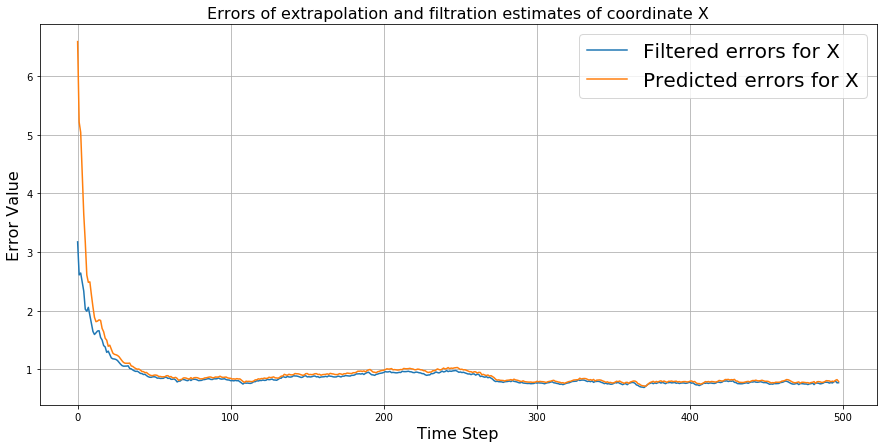

In [102]:
showPlease([x[0],x[1]],['Filtered errors for X','Predicted errors for X'],'Time Step','Error Value', 'Errors of extrapolation and filtration estimates of coordinate X')

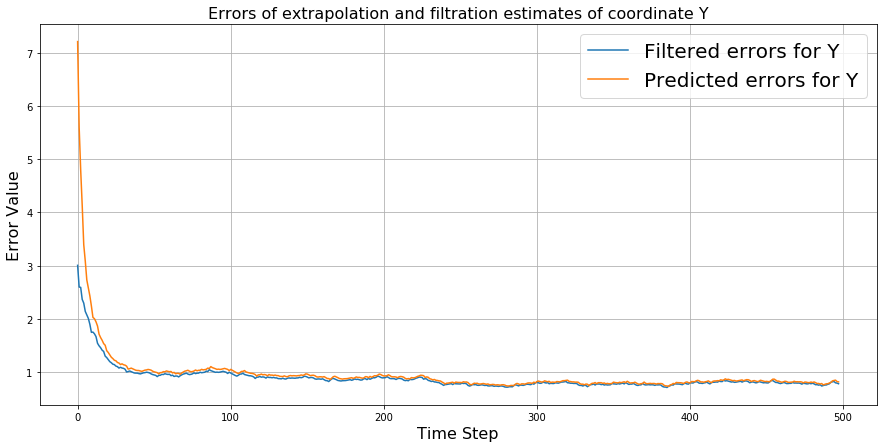

In [103]:
showPlease([y[0],y[1]],['Filtered errors for Y','Predicted errors for Y'],'Time Step','Error Value', 'Errors of extrapolation and filtration estimates of coordinate Y')

**It is seen from the graphs that true estimation errors of extrapolation and filtration estimates, in the case when only GPS data was used for both coordinates $x$ and $y$, are quantitatively quite similar - the value of less than one unit is achieved. This is much lower than the variances of measurement noise. However, there is some space to improve the results - it can be done by taking into consideration not only GPS data but also odometry data obtained in practice from wheel odometry sensors as well as the measurements of angle Θ in which comes simultaneously with GPS data (not direct odometry data).**

## Part II. Assimilation of both GPS data (absolute positioning) and wheel odometry data (relative positioning).

**Here we are again introducing the trajectory and the measurements of coordinates, then generating measurements of velocity V (in practice come from wheel odometry sensors) and measurements of angle Θ (come simultaneously wit GPS data).**

In [104]:
# handling different cases of arctan function's behaviour, as it's a component of observation function

def smartArc(x,y):
    if(x > 0):
        return np.arctan(y/x)
    elif(y > 0 and x < 0):
        return np.arctan(y/x) + np.pi
    elif(y < 0 and x < 0):
        return np.arctan(y/x) - np.pi
    elif(y > 0 and x == 0):
        return np.pi/2
    else:
        return -np.pi/2      

In [105]:
# function to generate measurements

def extend_meas(data):
    z = []
    process = copy.deepcopy(data.trueProcess)
    x = giveElements(process,0)
    y = giveElements(process,2)
    for i in range(0,len(process)):
        z.append(vector([x[i] + np.random.normal(0,data.externalNoiseSigma),
                         y[i] + np.random.normal(0,data.externalNoiseSigma),
                         10 + np.random.normal(0,0.5),
                         teta[i] + np.random.normal(0,0.02)]))
    data.measProcess = copy.deepcopy(z)
    data.initialVectorXK = np.matrix([[z[1].item(0)],
                             [(z[1].item(0) - z[0].item(0))/T],
                             [z[1].item(1)],
                             [(z[1].item(1) - z[0].item(1))/T]])
    return z
    

**With the knowledge from assignment 12 we are to develop Extended Kalman Filter to assimilate both GPS data and wheel odometry measurements. Working with nonlinear model we will need to linearize our measurements equation to execute the filtering algorithm correctly.**

In [106]:
def linearize(vector):
    Vx = vector.item(1,0)
    Vy = vector.item(3,0)
    return np.matrix([
                    [1,0,0, 0],
                    [0,0,1, 0],
                    [0,Vx/(Vx**2 + Vy**2)**0.5,0, Vy/(Vx**2 + Vy**2)**0.5],
                    [0, -Vy/(Vx**2 + Vy**2),0, Vx/(Vx**2 + Vy**2)]
                    ])
def h(vector):
    x = vector.item(0,0)
    Vx = vector.item(1,0)
    y = vector.item(2,0)
    Vy = vector.item(3,0)
    return np.matrix([
                    [x],
                    [y],
                    [(Vx**2+Vy**2)**0.5],
                    [smartArc(Vx,Vy)]
                     ])

class Extended_KalmanFilter:
    def __init__(self,dataForKalman):
        self.dataForKalman = dataForKalman
        self.kalmanVectors = None
        self.listK = None
        self.listP = None
        self.length = len(self.dataForKalman.trueProcess)
        
    def calculateKalmanVectors(self):
        self.kalmanVectors = []
        self.kalmanVectorsPr = []
        self.listK = []
        self.listP = []
        self.listPtr = []
        prevX = copy.deepcopy(self.dataForKalman.initialVectorXK)
        prevP = copy.deepcopy(self.dataForKalman.initialMatrixP.copy())
        if(self.dataForKalman.optimalK is not None):
            K = dataForKalman.optimalK
            for i in range(2,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i,None)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        else:
            for i in range(2,self.length):
                predictedX,predictedP = self.predict(prevX,prevP)
                dH = linearize(predictedX)
                K = self.calculateK(predictedP,dH)
                prevX,prevP = self.filtrate(predictedX,predictedP,K,i,dH)
                self.listP.append(prevP)
                self.kalmanVectors.append(prevX)
        #self.calculatePol()
        
    def predict(self,prevX,prevP):
        F = self.dataForKalman.F
        Q = self.dataForKalman.Q
        x = F*prevX
        P = F*prevP*F.T + Q
        self.kalmanVectorsPr.append(x)
        self.listPtr.append(P)
        return x, P
    
    def calculateK(self,predictedP,dH):
        R = np.matrix([[9,0,0,0],
                       [0,9,0,0],
                       [0,0,0.25,0],
                       [0,0,0,(0.02)**2]])
        K = predictedP*dH.T*(dH*predictedP*dH.T + R)**(-1)
        self.listK.append(K)
        return K
    
    def filtrate(self,predictedX,predictedP,K,measIndex,dH):
        meas = self.dataForKalman.measProcess[measIndex].copy()
        x = predictedX + K*(meas - h(predictedX))
        KH = K*dH
        P = (np.identity(KH.shape[0]) - KH) * predictedP
        return x,P
    
    
    def calculatePol(self):
        self.kalmanVectorsPol = []
        self.kalmanVectorsPolPr = []
        for i in self.kalmanVectors:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPol.append(vector([D,ang]))
        for i in self.kalmanVectorsPr:
            D,ang = polar(i.item(0,0),i.item(2,0))
            self.kalmanVectorsPolPr.append(vector([D,ang]))
    
    def extrapolate(self,step):
        predictions = []
        F = self.dataForKalman.F
        for i in range(step-1,self.length):
            predictions.append((F**(step - 1))*self.kalmanVectors[i - step + 1])
        return predictions
    
    def errors(self,values,index):
        start = 0
        errors = []
        if(len(values) < self.length):
            start = length - len(values)
        for i in range(start,self.length):
            errors.append(self.dataForKalman.trueVectorsOfProcess[i][index][0] - values[i - start ])
        return errors
    

**Now let's run constructed Kalman filter over M = 500 runs, calculate true estimation errors and plot them:**

In [107]:
def createProcessGiveKalman(data):
    motion(data)
    extend_meas(data)
    k = Extended_KalmanFilter(data)
    k.calculateKalmanVectors()
    return k

In [108]:
x_1,y_1 = manyKalman(data)

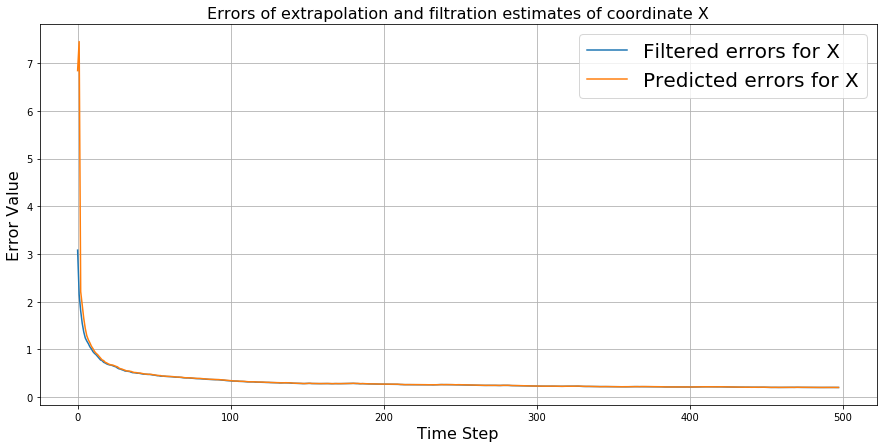

In [109]:
showPlease([x_1[0], x_1[1]], ['Filtered errors for X','Predicted errors for X'],'Time Step','Error Value', 'Errors of extrapolation and filtration estimates of coordinate X')

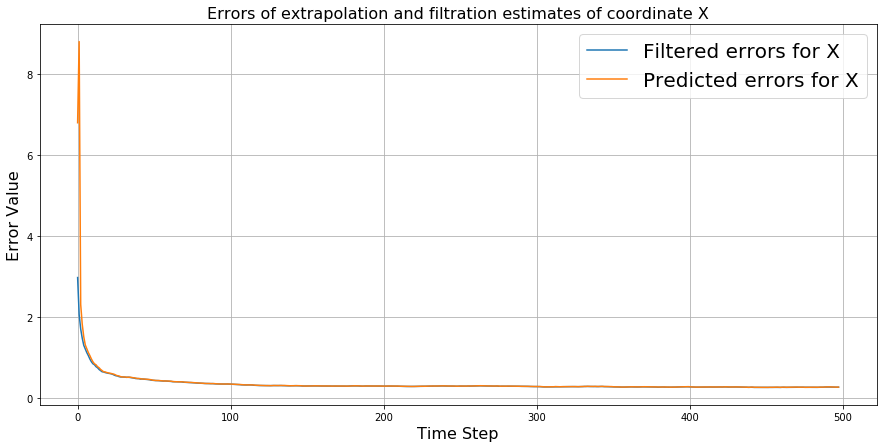

In [110]:
showPlease([y_1[0], y_1[1]],['Filtered errors for X','Predicted errors for X'],'Time Step','Error Value', 'Errors of extrapolation and filtration estimates of coordinate X')

**This time, when we took into consideration both GPS and odometry data, the estimation accuracy noteceable increased. The values of true estimation errors dropped up to the values of approximately 0.2 for both coordinates. Thus, Extended Kalman Filter provided us with even more accurate results than in the Part I of this assignment.**

**This final assignment provided us with a new approach of a vehicle tracking by assimilating the navigation data coming from different sources. Firstly, we saw that, although we had measurements coming only from one source, the accuracy of Kalman filter was still good. Secondly, we applied extended Kalman filter to obtain estimations of the vehicle's coordinates with higher accuracy — the accuracy indeed increased by approximately 4 times. It was also noted that errors for filtration and extrapolation turned out to be quite similar. The only thing we haven't learned yet is why we can spend 50+ hours on looking for an error in the code and it is usually found only one hour before the deadline. But that is a different story.**